# EBTEL Timelags

In [116]:
from collections import OrderedDict
import os
import tempfile
import subprocess

import numpy as np
from scipy.interpolate import splev,interp1d
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn
from synthesizAR.interfaces.ebtel import read_xml,write_xml
from synthesizAR.analysis import cross_correlation
from synthesizAR.instruments import InstrumentSDOAIA

%matplotlib inline

In [55]:
'EBTEL_DIR' in os.environ

False

In [231]:
config = {
    'total_time': 2e4,
    'tau': 1.0,
    'tau_max': 10.0,
    'loop_length': 4e9,
    'saturation_limit': 1,
    'force_single_fluid': False,
    'use_c1_loss_correction': True,
    'use_c1_grav_correction': True,
    'use_power_law_radiative_losses': True,
    'use_flux_limiting': True,
    'calculate_dem': False,
    'save_terms': False,
    'use_adaptive_solver': True,
    'adaptive_solver_error': 1e-6,
    'adaptive_solver_safety': 0.5,
    'c1_cond0': 2.0,
    'c1_rad0': 0.6,
    'helium_to_hydrogen_ratio': 0.075,
    'surface_gravity': 1.0,
    'heating': OrderedDict({
        'partition': 1.,
        'background': 1e-7,
        'events': [{'event': {'rise_start': 0.0,
                              'rise_end': 0.0,
                              'decay_start': 1.0,
                              'decay_end': 1.0, 
                              'magnitude': 0.01}}]
    }),
}

In [232]:
def run_ebtel(config, ebtel_dir):
    with tempfile.TemporaryDirectory() as tmpdir:
        config['output_filename'] = os.path.join(tmpdir, 'ebtelplusplus.tmp')
        write_xml(config,os.path.join(tmpdir,'ebtelplusplus.tmp.xml'))
        subprocess.call([os.path.join(ebtel_dir, 'bin', 'ebtel++.run'),
                         '-c', os.path.join(tmpdir,'ebtelplusplus.tmp.xml')])
        data = np.loadtxt(config['output_filename'])
    return {
        'time': data[:, 0]*u.s,
        'electron_temperature': data[:, 1]*u.K,
        'ion_temperature': data[:, 2]*u.K,
        'density': data[:, 3]/(u.cm**3),
        'electron_pressure': data[:, 4]*u.dyne/(u.cm**2),
        'ion_pressure': data[:, 5]*u.dyne/(u.cm**2), 
        'velocity': data[:, 6]*u.cm/u.s,
    }

In [233]:
aia = InstrumentSDOAIA([0,1]*u.s,None)

In [234]:
res = run_ebtel(config,'/Users/willbarnes/Documents/work/codes/ebtelPlusPlus/')

In [237]:
Te[[0,-1]].to(u.MK)

<Quantity [5.268782 , 0.2158809] MK>

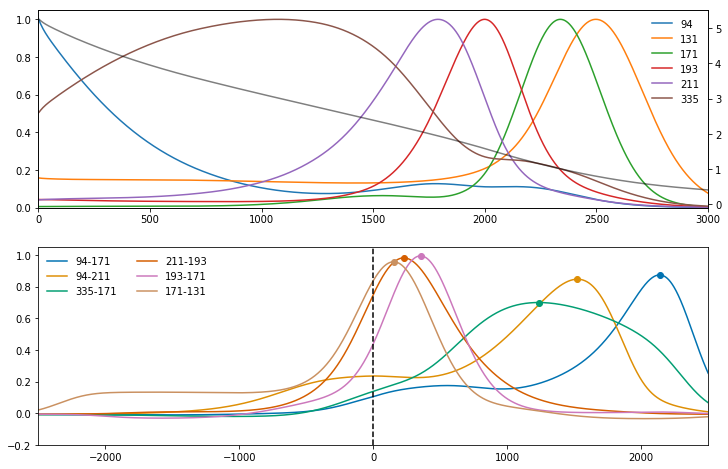

In [236]:
fig = plt.figure(figsize=(12,8))
# Lightcurves
ax = fig.add_subplot(211,)
intensity = {}
t = np.arange(res['time'][0].value,res['time'][-1].value,1)*res['time'].unit
Te = interp1d(res['time'].value,res['electron_temperature'].value)(t.value)*res['electron_temperature'].unit
n = interp1d(res['time'].value,res['density'].value)(t.value)*res['density'].unit
for c in aia.channels:
    K = splev(Te.value, c['temperature_response_spline'])
    I = config['loop_length']*K*(n**2)
    intensity[c['name']] = I
    ax.plot(t,I/I.max(),label=f'{c["wavelength"].value:.0f}')
ax2 = ax.twinx()
ax2.plot(t,Te.to(u.MK),color='k',alpha=0.5)
ax.legend(loc=1,frameon=False)
ax.set_xlim(0,3e3)
ax.set_ylim(0,1.05)
#ax2.set_ylim(0.1,5)
# Cross-correlations
ax = fig.add_subplot(212,)
pairs = [
    #(94,335),
    (94,171),
    #(94,193),
    #(94,131),
    (94,211),
    #(335,131),
    #(335,193),
    #(335,211),
    (335,171),
    #(211,131),
    #(211,171),
    (211,193),
    (193,171),
    #(193,131),
    (171,131),
]
for i,(a,b) in enumerate(pairs):
    tl,cc = cross_correlation(t[:],intensity[f'{a}'][:],intensity[f'{b}'][:])
    ax.plot(tl,cc,label=f'{a}-{b}',color=seaborn.color_palette('colorblind',n_colors=len(pairs))[i])
    ax.plot(tl[np.argmax(cc)],cc.max(),marker='o',ls='',color=seaborn.color_palette('colorblind',n_colors=len(pairs))[i])
ax.axvline(x=0,ls='--',color='k')
ax.set_xlim(-2.5e3,2.5e3)
ax.set_ylim(-0.2,1.05)
ax.legend(loc=2,frameon=False,ncol=2)

(0, 3250)

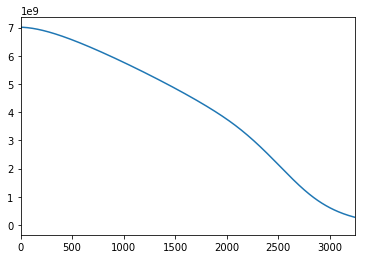

In [239]:
plt.plot(res['time'],res['density'])
plt.xlim(0,3250)